In [37]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import pairwise_distances, silhouette_samples, silhouette_score
from sklearn.cluster import KMeans, MiniBatchKMeans
from scipy.spatial.distance import cosine
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Helper Methods

In [38]:
def compute_cohesion(clusters, X):
    cohesion = 0
    for cluster_label in np.unique(clusters):
        cluster_points = X[clusters == cluster_label]
        if len(cluster_points) > 1:
            pairwise_dists = pairwise_distances(cluster_points)
            cohesion += pairwise_dists.sum() / 2
    return cohesion

def compute_separation(clusters, X):
    centroids = []
    for cluster_label in np.unique(clusters):
        cluster_points = X[clusters == cluster_label]
        centroids.append(cluster_points.mean(axis=0))
    centroids = np.array(centroids)
    overall_centroid = X.mean(axis=0)
    separation = 0
    for cluster_label, centroid in zip(np.unique(clusters), centroids):
        cluster_points = X[clusters == cluster_label]
        centroid_dist = np.linalg.norm(centroid - overall_centroid) ** 2
        separation += len(cluster_points) * centroid_dist
    return separation

In [39]:
## method used to extract the 10 most common terms after clustering
def getMostCommonTerms(tweetVectorDf, clusterArray, cluster):
    tweetVectorDf['clusters'] = clusterArray  # Add column corresponding to cluster number
    ## sum word frequencies for each cluster
    word_frequencies_by_cluster = tweetVectorDf.groupby('clusters').sum()
    ## return dataframe for individual cluster with values for word frequency sorted by most frequent to least
    word_frequencies_for_individual_cluster = word_frequencies_by_cluster.loc[cluster, :].sort_values(ascending=False)
    return (word_frequencies_for_individual_cluster[:10])

# Loading data into pandas

In [40]:
## get tweets from our repo
data = pd.read_csv(r"../inputdata/cnnhealth.txt", sep="|", header=None, on_bad_lines='skip')

In [41]:
print("Data in its unedited state: ")
print(data)

Data in its unedited state: 
                       0                               1  \
0     576880531301801984  Sat Mar 14 23:00:11 +0000 2015   
1     576820122666471424  Sat Mar 14 19:00:08 +0000 2015   
2     576744652717461504  Sat Mar 14 14:00:15 +0000 2015   
3     576736754436304896  Sat Mar 14 13:28:52 +0000 2015   
4     576736614766010368  Sat Mar 14 13:28:18 +0000 2015   
...                  ...                             ...   
4040  239699936671854593  Sun Aug 26 12:24:52 +0000 2012   
4041  239504620710420480  Sat Aug 25 23:28:46 +0000 2012   
4042  239410205757145088  Sat Aug 25 17:13:35 +0000 2012   
4043  239386320416428032  Sat Aug 25 15:38:41 +0000 2012   
4044  239366825018806272  Sat Aug 25 14:21:12 +0000 2012   

                                                      2  
0     An abundance of online info can turn us into e...  
1     A plant-based diet that incorporates fish may ...  
2     It doesn't take much to damage your hearing at...  
3     RT @CNN: For

## Removing urls from our tweets.
One potential way to remove non-meaningful information such as server locations from the url path. Another potential method could be adding appearance thresholds for certain words i.e. if B8VAgxHCYAETD6L.jpg does not appear more than once, then remove it from our pool. There may be some meaningful information lost when removing the url. Nearly all tweets have embedded links for cnn.com, so keeping those will not help us better classify/differentiate the tweets. However, some are for pbs, instagram, etc. so could prove meaningful as a differentiator for clustering.

In [42]:
data[2] = data[2].replace('(https?:\/\/)(?:([^\n ]*))?', '', regex=True)

In [43]:
## Take tweets column from dataframa and convert it to an array so we can preform vector operations on it
tweets = data[2].to_numpy()

In [44]:
print(tweets)

['An abundance of online info can turn us into e-hypochondriacs. Or, worse, lead us to neglect getting the care we need '
 'A plant-based diet that incorporates fish may be the key to preventing colorectal cancers:  '
 "It doesn't take much to damage your hearing at a sports bar or nightclub. That's why a billion people are at risk. "
 ... 'Ann Romney talks about her experience with MS '
 "Make sure your first marathon isn't your last! "
 "Robin Roberts' cancer diagnosis "]


### Create tfid vectorizer, passing the standard english stop words set as a parameter (removes words such as 'and', 'it' and punctuation, etc.)
we also set the max document frequency to 50% (if a word appears in more than 50% of documents, we want to ignore it) set min document frequency to 5 (if a word does not appear in at least 5 tweets, we disregard it)

In [45]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=5)

In [46]:
vectorizer.fit(tweets)

TfidfVectorizer(max_df=0.5, min_df=5, stop_words='english')

In [47]:
## get array of unique words across all documents
names = vectorizer.get_feature_names_out()
## for older version of sklearn
# names = vectorizer.get_feature_names()

In [48]:
#print(len(names))

In [49]:
features = vectorizer.fit_transform(tweets)
features

<4045x1311 sparse matrix of type '<class 'numpy.float64'>'
	with 21338 stored elements in Compressed Sparse Row format>

In [50]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

tweets_stats = tweets.tolist()


# Average length of tweets (in words)
avg_tweet_word_length = np.mean([len(word_tokenize(tweet)) for tweet in tweets])


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kvron\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [51]:
count_vectorizer = CountVectorizer(stop_words='english', max_df=0.5, min_df=5)
count_matrix = count_vectorizer.fit_transform(tweets)

feature_names = count_vectorizer.get_feature_names_out()
count_df = pd.DataFrame(count_matrix.toarray(), columns=feature_names)
# Sum the term frequency for each word (column-wise)
word_frequencies = count_df.sum(axis=0)

In [52]:
num_tweets = len(tweets)
num_unique_words = len(names)
avg_words_per_tweet = features.sum() / num_tweets

print(f"Number of tweets: {num_tweets}")
print(f"Number of unique words: {num_unique_words}")
print(f"Average uniquewords per tweet: {avg_words_per_tweet}")
print(f"Average tweet length (words): {avg_tweet_word_length}")
print("Top 10 most frequent words:")
print(word_frequencies.nlargest(10))


Number of tweets: 4045
Number of unique words: 1311
Average uniquewords per tweet: 2.1834310748600383
Average tweet length (words): 15.877379480840544
Top 10 most frequent words:
rt           643
getfit       257
health       253
today        209
cnnhealth    202
new          184
says         168
amp          166
cnn          161
cancer       156
dtype: int64


In [53]:
tweetVectors = features.toarray()

In [54]:
print(tweetVectors)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [55]:
tweetVectorDataFrame = pd.DataFrame(tweetVectors, columns=names);

In [56]:
tweetVectorDataFrame.to_csv(r'../outputdata/featurematrix.csv', index=None)

# Calculating Distance Measures
## Cosine similarity measure

In [57]:
cosine_similarity = 1-pairwise_distances(tweetVectors, metric="cosine")
cosine_similarity

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [58]:
cosineSimilarityDf = pd.DataFrame(cosine_similarity);
cosineSimilarityDf.to_csv(r'../outputdata/cosinesimilarity.csv', index=None, header=None)

### Jaccard Similarity measure

In [59]:
from sklearn.metrics import jaccard_score

# Calculate pairwise Jaccard similarities
jaccard_similarities = 1 - pairwise_distances(tweetVectors, metric='jaccard')
jaccard_similarities

C:\Users\kvron\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [60]:
jaccardSimilarityDf = pd.DataFrame(jaccard_similarities)
jaccardSimilarityDf.to_csv(r'../outputdata/jaccard_similarities.csv', index=None, header=None)

## Visualizing the distance distributions

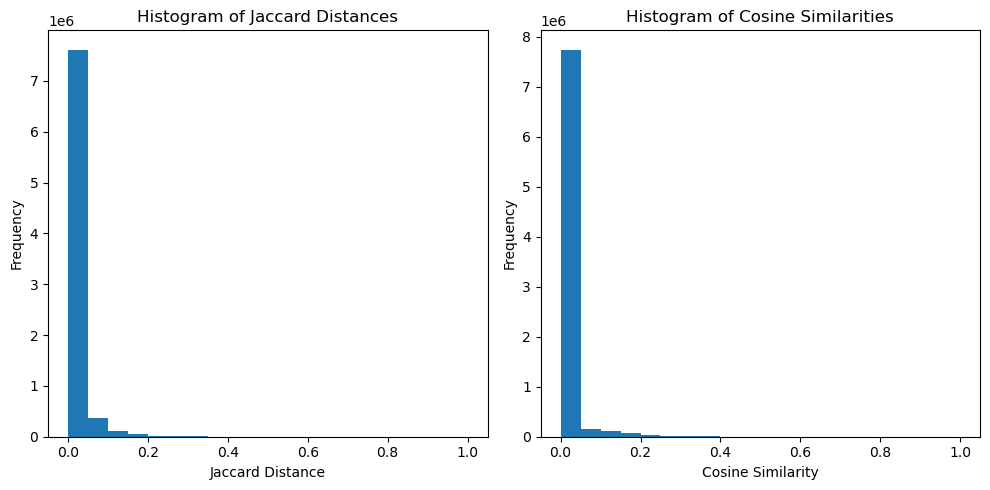

In [61]:
# Flatten the distance matrices and remove self-distances (i.e., distance of a tweet to itself)
jaccard_similarities_flat = jaccard_similarities[np.triu_indices(num_tweets, k=1)]
cosine_similarities_flat = cosine_similarity[np.triu_indices(num_tweets, k=1)]

# Plot the histograms
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(jaccard_similarities_flat, bins=20)
plt.xlabel('Jaccard Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Jaccard Distances')

plt.subplot(1, 2, 2)
plt.hist(cosine_similarities_flat, bins=20)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Histogram of Cosine Similarities')

plt.tight_layout()
plt.show()

## DBSCAN Clustering with Jaccard Similarity

In [62]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

eps_values = np.arange(0.2, 1.0, 0.05)  # Adjust the start, end, and step values as needed
min_samples_values = np.arange(5, 50, 2)  # Adjust the start, end, and step values as needed

best_eps = None
best_min_samples = None
best_score = -1
X = 1-jaccard_similarities

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')
        clusters = dbscan.fit_predict(1-jaccard_similarities)
        
        # Calculate silhouette score only for valid clusterings
        n_clusters = len(np.unique(clusters))
        if n_clusters > 10 and n_clusters < len(clusters):
            score = silhouette_score(X, clusters, metric='precomputed')
            cohesion = compute_cohesion(clusters, X)
            separation = compute_separation(clusters, X)
            if score > best_score:
                best_n_clusters = n_clusters
                best_score = score
                best_eps = eps
                best_min_samples = min_samples
                best_cohesion = cohesion
                best_seperation = separation

print(f"Best Silhouette Score: {best_score}")
print(f"Best eps value: {best_eps}")
print(f"Best min_samples value: {best_min_samples}")
print(f"Best n_clusters: {best_n_clusters}")
print(f"Best Cohesions: {best_cohesion}")
print(f"Best Seperation: {best_seperation}")

Best Silhouette Score: 0.000798137582731499
Best eps value: 0.7499999999999998
Best min_samples value: 15
Best n_clusters: 13
Best Cohesions: 11847509.407007558
Best Seperation: 3267.5062367252735


In [63]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# Set the parameters for DBSCAN clustering
eps = 0.7499999999999998
min_samples = 15

# Create a DBSCAN clustering instance with the Jaccard distance matrix
dbscan = DBSCAN(eps=eps, min_samples= min_samples, metric='precomputed')

# Fit the DBSCAN instance to the Jaccard distance matri
clusters = dbscan.fit_predict(1-jaccard_similarities)

n_clusters = len(np.unique(clusters))


In [64]:
clusters = dbscan.fit_predict(1-jaccard_similarities)

C:\Users\kvron\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\kvron\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


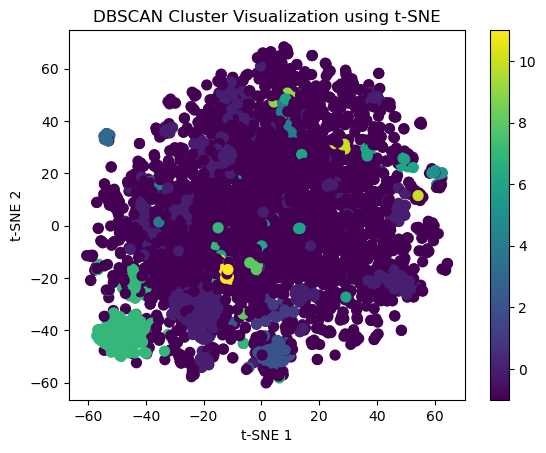

In [65]:
from sklearn.manifold import TSNE
# Assuming 'features' is already created

binary_matrix = (features > 0).astype(int)
dense_binary_matrix = binary_matrix.toarray()

tsne = TSNE(n_components=2, metric='cosine', random_state=42, init='random')
reduced_data = tsne.fit_transform(dense_binary_matrix)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', marker='o', s=50)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('DBSCAN Cluster Visualization using t-SNE')
plt.colorbar()
plt.show()

terms = getMostCommonTerms(tweetVectorDataFrame, dbscan.labels_, 11);
print(terms) 

In [66]:
cluster_ids, cluster_sizes = np.unique(dbscan.labels_, return_counts=True)
print(cluster_sizes)

[2923  662   26   68   17   17   14   50  213   14   13   13   15]


In [67]:
from sklearn.metrics import silhouette_score

score = silhouette_score(1-jaccard_similarities, clusters, metric='precomputed')
print("Silhouette Score:", score)

Silhouette Score: 0.000798137582731499


## K-Means Clustering with the Cosine Similarity Matrix

In [68]:
kmeans = KMeans()

In [69]:
inertia = []

for i in range(1, 30):
    kmeans = KMeans(n_clusters=i, n_init=10, max_iter=300, random_state=0)
    kmeans.fit(cosine_similarity)
    inertia.append(kmeans.inertia_)

C:\Users\kvron\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=16.
  warnings.warn(


In [70]:
print(inertia)

[27488.72984377276, 26204.653401921398, 25048.39925774107, 24428.690726458386, 24042.648966209574, 23734.02533838538, 23513.940997831854, 23320.355391371177, 22820.189140758717, 22613.143774010525, 22399.284743074866, 22321.41207979752, 22315.93756364537, 22029.94084884808, 21811.435165219584, 21647.019938498008, 21433.479842226843, 21269.37749794907, 21281.88536291926, 21184.728996637736, 20941.21246806891, 20874.865420390266, 20761.16578769529, 20695.598980326027, 20659.468201279535, 20453.44350179569, 20324.286596714355, 20269.632022560723, 20170.087352376813]


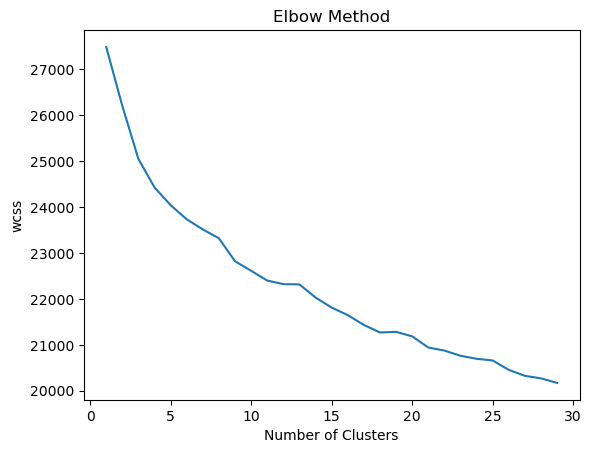

In [71]:
plt.plot(range(1,30), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.show()

In [99]:
kmeans = KMeans(n_clusters=8, n_init=10, max_iter=300, random_state=0)
output = kmeans.fit_predict(cosine_similarity)
cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
print(cluster_sizes)

[ 118   76  520 2649  120  231  170  161]


C:\Users\kvron\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\kvron\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


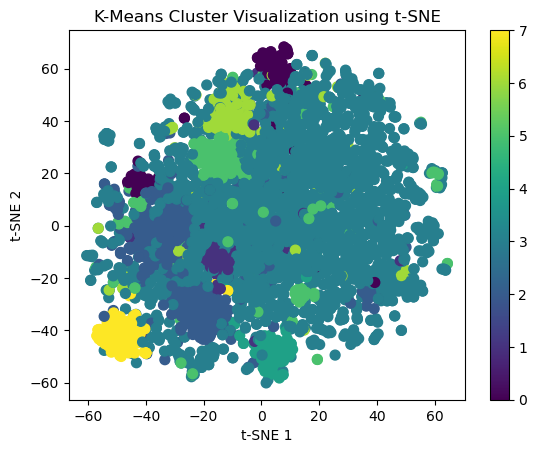

In [100]:
dense_binary_matrix = binary_matrix.toarray()

tsne = TSNE(n_components=2, metric='cosine', random_state=42, init='random')
reduced_data = tsne.fit_transform(dense_binary_matrix)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap='viridis', marker='o', s=50)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('K-Means Cluster Visualization using t-SNE')
plt.colorbar()
plt.show()

In [101]:
cohesion = compute_cohesion(output, 1-cosine_similarity)
separation = compute_separation(output, 1-cosine_similarity)
score = silhouette_score(1-cosine_similarity, output, metric='precomputed')

print("Silhouette Score:", score)
print("Cohesion (SSE):", cohesion)
print("Separation (BSS):", separation)

Silhouette Score: 0.023792382625474482
Cohesion (SSE): 12630636.354194308
Separation (BSS): 4168.37445240156


In [102]:
terms = getMostCommonTerms(tweetVectorDataFrame, kmeans.labels_, 4);

In [103]:
print(terms)

pounds            22.220645
weightloss        20.587460
lost              20.090318
getfit            13.795719
lbs               10.996503
transformation     6.959387
lose               5.950106
100                4.318177
weeklyweighin      4.252137
drops              3.817784
Name: 4, dtype: float64


# Spectral Clustering

In [76]:
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering

In [77]:
cosine_similarity = 1-pairwise_distances(tweetVectors, metric="cosine")
cosine_similarity

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [78]:
n_clusters = 8
cosine_similarity = 1-pairwise_distances(tweetVectors, metric="cosine")


inertia = []

for i in range(2, 15):
    spectral_clustering = SpectralClustering(n_clusters=i, affinity='nearest_neighbors')
    spectraoutl_clusters = spectral_clustering.fit_predict(1-cosine_similarity)
    score = silhouette_score(1-cosine_similarity, spectral_clusters, metric='precomputed')
    inertia.append(score)

print(inertia)

spectral_clustering = SpectralClustering(n_clusters=8, affinity='nearest_neighbors')
spectral_clusters = spectral_clustering.fit_predict(1-cosine_similarity)


C:\Users\kvron\anaconda3\lib\site-packages\sklearn\cluster\_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\kvron\anaconda3\lib\site-packages\sklearn\cluster\_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\kvron\anaconda3\lib\site-packages\sklearn\cluster\_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(
C:\Users\kvron\anaconda3\lib\site-packages\sklearn\cluster\_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity mat

[0.008507048549269123, 0.007537893749302734, 0.0077251382223485045, 0.009005514378689662, 0.010965156871231679, 0.012565273657517303, 0.011319475518434296, 0.012872929759134547, 0.015086419396495295, 0.016292193560940443, 0.016758918880421903, 0.016131750202270756, 0.01513483642229794]


C:\Users\kvron\anaconda3\lib\site-packages\sklearn\cluster\_spectral.py:589: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn(


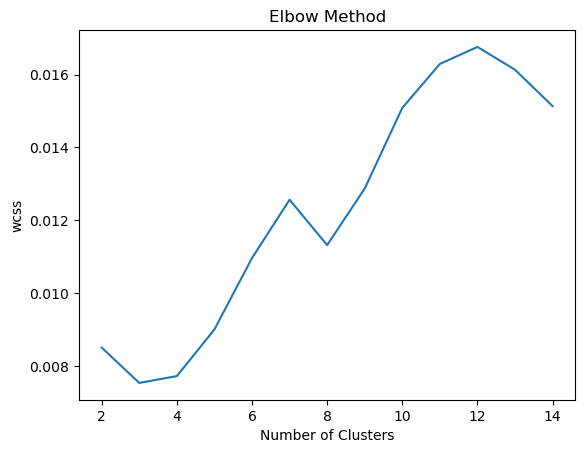

In [79]:
plt.plot(range(2,15), inertia)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('wcss')
plt.show()

In [80]:
cohesion = compute_cohesion(clusters, 1-cosine_similarity)
separation = compute_separation(clusters, 1-cosine_similarity)
score = silhouette_score(1-cosine_similarity, spectral_clusters, metric='precomputed')

print("Silhouette Score:", score)
print("Cohesion (SSE):", cohesion)
print("Separation (BSS):", separation)

Silhouette Score: 0.011319475518434296
Cohesion (SSE): 15443503.976101806
Separation (BSS): 2396.5883377462533


In [81]:
cluster_ids, cluster_sizes = np.unique(spectral_clustering.labels_, return_counts=True)
print(cluster_sizes)

[ 193 3304  156  101   37   16   54  184]


C:\Users\kvron\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\kvron\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


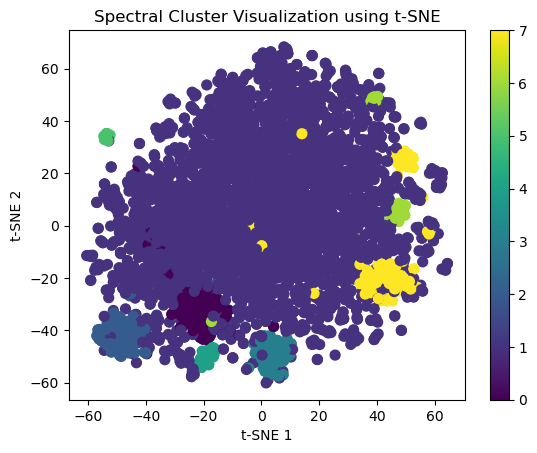

In [82]:
dense_binary_matrix = binary_matrix.toarray()

tsne = TSNE(n_components=2, metric='cosine', random_state=42, init='random')
reduced_data = tsne.fit_transform(dense_binary_matrix)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=spectral_clustering.labels_, cmap='viridis', marker='o', s=50)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Spectral Cluster Visualization using t-SNE')
plt.colorbar()
plt.show()

## MiniBatchKMeans Clustering using Jaccard Similarity

In [83]:
## Fit data with MiniBatchKMeans Clustering algorithm for a number of different clusters
scores_per_n = [MiniBatchKMeans(n_clusters=n, n_init=10, max_iter=300, random_state=0).fit(jaccard_similarities) for n in range(1,11)]

C:\Users\kvron\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 8192 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Users\kvron\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 8192 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\Users\kvron\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 8192 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(
C:\User

In [84]:
## Gather silhouette scores for each iteration
silhouette_scores = [silhouette_score(jaccard_similarities, iteration.labels_) for iteration in scores_per_n[1:]]

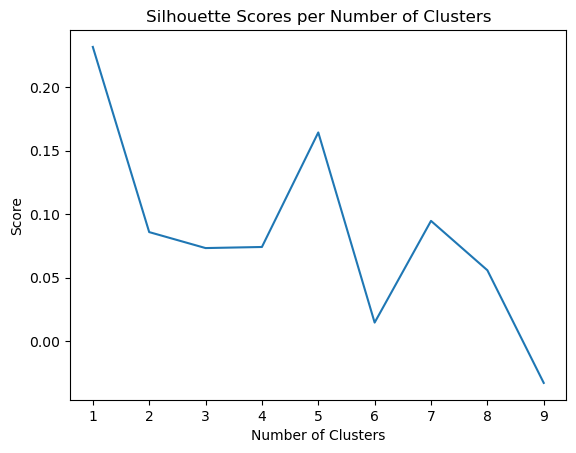

In [85]:
plt.plot(range(1,10), silhouette_scores)
plt.title('Silhouette Scores per Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

In [96]:
minibatch = MiniBatchKMeans(n_clusters=5, n_init=10, max_iter=300, random_state=0)
output = minibatch.fit_predict(jaccard_similarities)
cluster_ids, cluster_sizes = np.unique(minibatch.labels_, return_counts=True)
print(cluster_sizes)

C:\Users\kvron\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 8192 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


[ 179  425 3161  196   84]


C:\Users\kvron\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\kvron\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


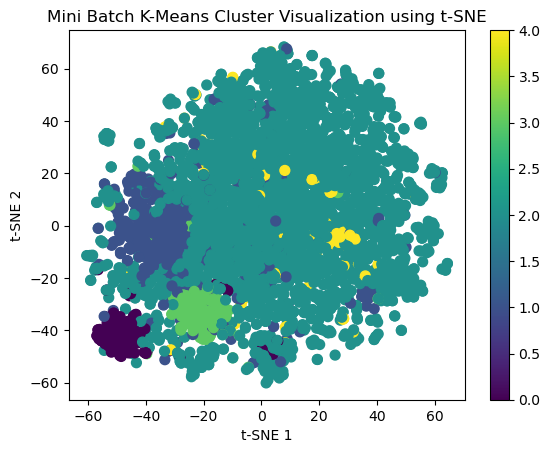

In [97]:
dense_binary_matrix = binary_matrix.toarray()

tsne = TSNE(n_components=2, metric='cosine', random_state=42, init='random')
reduced_data = tsne.fit_transform(dense_binary_matrix)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=minibatch.labels_, cmap='viridis', marker='o', s=50)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Mini Batch K-Means Cluster Visualization using t-SNE')
plt.colorbar()
plt.show()

In [98]:
cohesion = compute_cohesion(output, 1-cosine_similarity)
separation = compute_separation(output, 1-cosine_similarity)
score = silhouette_score(1-cosine_similarity, output, metric='precomputed')

print("Silhouette Score:", score)
print("Cohesion (SSE):", cohesion)
print("Separation (BSS):", separation)

Silhouette Score: 0.010317196843388145
Cohesion (SSE): 17946600.101445917
Separation (BSS): 2873.0760493611747


In [88]:
terms = getMostCommonTerms(tweetVectorDataFrame, minibatch.labels_, 3);

In [89]:
print(terms)

cnnhealth          55.571916
rt                 43.579698
amp                 8.620779
allergyreliefny     7.665573
great               5.023488
article             4.522018
cnn                 4.008437
yes                 4.005067
cnnallergies        3.922952
williamcnn          2.872657
Name: 3, dtype: float64


# Evaluating the Entropy and Purity
Looks like we need to select two of our clustering algos that produce the same amount of clusters because we do not have the true labels for the clusters
So I selected the K-means clusters and the spectral clusters because they both have 8 clusters
Then using the clusters from k-means and from spectral clustering we created a confusion matrix.

In [90]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(output, spectral_clusters)

cm

array([[   0,  115,    0,    0,    0,    0,    1,    2],
       [   0,   76,    0,    0,    0,    0,    0,    0],
       [ 193,  312,    0,    0,    0,    0,    3,   12],
       [   0, 2388,    0,    1,   37,   16,   47,  160],
       [   0,   18,    0,  100,    0,    0,    0,    2],
       [   0,  228,    0,    0,    0,    0,    2,    1],
       [   0,  162,    0,    0,    0,    0,    1,    7],
       [   0,    5,  156,    0,    0,    0,    0,    0]], dtype=int64)

In [91]:
# The purity is caluclated below

In [92]:
purity = np.sum(np.max(cm, axis=0)) / np.sum(cm)
print(f"Purity: {purity}")

Purity: 0.7656365883807169


In [93]:
# the entropy is the sum of - probablitiy * log2(probabilites)

In [94]:
def entropy(cluster_counts):
    cluster_size = np.sum(cluster_counts)
    probabilities = cluster_counts / cluster_size
    return -np.sum(probabilities * np.log2(probabilities + np.finfo(float).eps))

cluster_entropies = np.apply_along_axis(entropy, 1, cm)
weighted_entropies = (np.sum(cm, axis=1) / np.sum(cm)) * cluster_entropies
total_entropy = np.sum(weighted_entropies)

print(f"Entropy: {total_entropy}")

Entropy: 0.6053349266433427
